The goal of this test is to get two groups of cells to have the same connetions

In [1]:
from brian2 import *
from matplotlib import *
import numpy as np
import random
import pandas as pd
import os
import time

In [2]:
#Parameters Block
activeMF_fraction = 0.2 # Int, (decimal notion) fraction of active mossy fibers
activeMF_seed     = 451 # Int or None, if user wishes to seed the random active mossy fiber call

# Cell numbers to reproduce functionally relevant 100um^3 cube of granular layer
nmf  =  315                 # Mossy fibers
nGrC = 4096                 # Granule cells
nGoC =   27                 # Golgi cells

# Convergence ratios of connections (to determine connection probabilities)
conv_GrC_M   =   4          #  mf -> GrC synapses
conv_GoC_M   =  50          #  mf -> GoC synapses
conv_GoC_GrC = 100          # GrC -> GoC synapses
conv_GrC_GoC =   4          # Goc -> GrC synapses

# Leak conductance
g_l_GrC   = 0.4   * nS
g_t_GrC   = 0.4   * nS

g_l_GoC   = 3.    * nS

# Reversal potential (leak, excitatory, inhibitory)
E_l_GrC   = -75   * mV
E_e_GrC   =   0   * mV
E_i_GrC   = -75   * mV

E_l_GoC   = -50   * mV
E_e_GoC   =   0   * mV
E_i_GoC   = -75   * mV

# Membrane capacitance
C_m_GrC   =  3.1  * pF
C_m_GoC   = 60.   * pF

# TODO Use rise and decay times and add dyanmics to neuron Equations
tau_e_decay_GrC = 6.0 * ms
tau_e_decay_GoC = 3.0 * ms

tau_i_decay_GrC = 15.0 * ms

# Absolute refractory period
tau_r_GrC = 2 * ms
tau_r_GoC = 40* ms

# Spiking threshold
V_th_GrC   = -55 * mV
V_th_GoC   = -50 * mV

# Resting potential
V_r_GrC    = -75 * mV
V_r_GoC    = -55 * mV

# Golgi cell reset potential
V_reset_GoC = -60 * mV

# Synaptic weights
w_e_GrC = 0.65 * nS
w_i_GrC = 0.08 * nS

w_e_GoC_M = 0.35  * nS
w_e_GoC_GrC = 0.0 * nS

# Stochastic fluctuating excitatory current
sigma_n_GoC = 0.01 * nS
sigma_n_GrC = 0.03 * nS

tau_n   = 20 * ms

### Brian 2 Code (do not segment the following cell)

In [3]:
#Brian 2 Code Block

#neuron equations
GoC_eqs = '''
dv/dt   = (g_l*(E_l-v) + (g_e+g_n)*(E_e-v))/C_m : volt (unless refractory)
dg_e/dt = -g_e/tau_e : siemens
dg_n/dt = (-g_n + sigma_n_GoC * sqrt(tau_n) * xi)/tau_n : siemens
'''

# mossy fiber input
stim_times = [1010, 1020, 1030]            # Mossy fiber stimulation times
nstim      = len(stim_times)

# Randomly select a subset of mossy fibers to spike at each stimulation
# If you want a different subset of mossy fibers at each stimulation, move
# the declaration of [active_indices] into the loop over stim_times

if activeMF_seed is not None: np.random.seed(activeMF_seed) #seed value
active_indices = sorted(np.random.choice(nmf, round(nmf * activeMF_fraction), replace=False)) 
indices    = []
times      = []
for j in range(nstim):
    indices.extend(active_indices)
    times.extend([stim_times[j]]*len(active_indices))
times    = times * ms
mf_input = SpikeGeneratorGroup(nmf, indices, times)

#neurons 
GoC1 = NeuronGroup(nGoC,
                   Equations(GoC_eqs,
                             g_l = g_l_GoC,
                             E_l = E_l_GoC,
                             E_e = E_e_GoC,
                             E_i = E_i_GoC,
                             C_m = C_m_GoC,
                             tau_e = tau_e_decay_GoC),
                   threshold  = 'v > V_th_GoC',
                   reset      = 'v = V_reset_GoC',
                   refractory = 'tau_r_GoC',
                   method     = 'euler')
GoC1.v = V_r_GoC

GoC2 = NeuronGroup(nGoC,
                   Equations(GoC_eqs,
                             g_l = g_l_GoC,
                             E_l = E_l_GoC,
                             E_e = E_e_GoC,
                             E_i = E_i_GoC,
                             C_m = C_m_GoC,
                             tau_e = tau_e_decay_GoC),
                   threshold  = 'v > V_th_GoC',
                   reset      = 'v = V_reset_GoC',
                   refractory = 'tau_r_GoC',
                   method     = 'euler')
GoC2.v = V_r_GoC

GoC3 = NeuronGroup(nGoC,
                   Equations(GoC_eqs,
                             g_l = g_l_GoC,
                             E_l = E_l_GoC,
                             E_e = E_e_GoC,
                             E_i = E_i_GoC,
                             C_m = C_m_GoC,
                             tau_e = tau_e_decay_GoC),
                   threshold  = 'v > V_th_GoC',
                   reset      = 'v = V_reset_GoC',
                   refractory = 'tau_r_GoC',
                   method     = 'euler')
GoC3.v = V_r_GoC

#synaptic connections
GoC1_M = Synapses(mf_input,GoC1,
                  on_pre = 'g_e += w_e_GoC_M')
GoC1_M.connect(p = conv_GoC_M/nmf)

GoC2_M = Synapses(mf_input,GoC2,
                  on_pre = 'g_e += w_e_GoC_M')
GoC2_M.connect(i= GoC1_M.i[:], j= GoC1_M.j[:])

GoC3_M = Synapses(mf_input,GoC3,
                  on_pre = 'g_e += w_e_GoC_M')
GoC3_M.connect(p = conv_GoC_M/nmf)

#simulation
spikemon_GoC1 = SpikeMonitor(GoC1)
spikemon_GoC2 = SpikeMonitor(GoC2)
spikemon_GoC3 = SpikeMonitor(GoC3)

runtime = 2000
run(runtime * ms, report='stdout', report_period=5*second,
    profile=True)

Starting simulation at t=0. s for a duration of 2. s
2.0 (100%) simulated in 3s


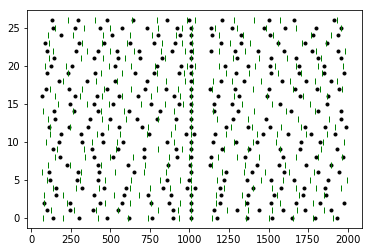

In [4]:
plot(spikemon_GoC1.t/ms, spikemon_GoC1.i, '.k')
plot(spikemon_GoC2.t/ms, spikemon_GoC2.i, '|g')

Lets check the connections

In [5]:
mf_goc1 = pd.DataFrame({'mf': GoC1_M.i[:],'GoC':GoC1_M.j[:]})
mf_goc2 = pd.DataFrame({'mf': GoC2_M.i[:],'GoC':GoC2_M.j[:]})
mf_goc3 = pd.DataFrame({'mf': GoC3_M.i[:],'GoC':GoC3_M.j[:]})

In [6]:
net_connections = pd.concat([mf_goc1.set_index(mf_goc1.index), mf_goc2.set_index(mf_goc2.index), 
                            mf_goc3.set_index(mf_goc3.index)], axis='columns', keys=['group1', 'group2', 
                                                                                     'grp3-control'])

In [7]:
net_connections.head(10)

group1       group2       grp3-control    
      mf   GoC     mf   GoC           mf GoC
0    0.0   4.0    0.0   4.0            0   4
1    0.0  11.0    0.0  11.0            0   7
2    0.0  14.0    0.0  14.0            0  10
3    0.0  15.0    0.0  15.0            0  12
4    0.0  24.0    0.0  24.0            0  18
5    1.0   0.0    1.0   0.0            0  24
6    1.0   6.0    1.0   6.0            1   5
7    1.0  14.0    1.0  14.0            1  10
8    1.0  15.0    1.0  15.0            1  24
9    2.0  13.0    2.0  13.0            2   1

It works

In [8]:
net_connections.tail()

group1     group2     grp3-control    
         mf GoC     mf GoC           mf GoC
1393    NaN NaN    NaN NaN          314   3
1394    NaN NaN    NaN NaN          314   6
1395    NaN NaN    NaN NaN          314   7
1396    NaN NaN    NaN NaN          314  10
1397    NaN NaN    NaN NaN          314  12

In [9]:
net_connections.loc[:, (('group1', 'group2'), 'GoC')].diff(axis=1).head(30)

,group1,group2
,GoC,GoC
0,NaN,0.0
1,NaN,0.0
2,NaN,0.0
3,NaN,0.0
4,NaN,0.0
5,NaN,0.0
6,NaN,0.0
7,NaN,0.0
8,NaN,0.0
